# In this Project we implement classification for CIFAR 10 dataset using deep learning methods and Local Binary Pattern.

### 1)  Implementing CIFAR10 using Deep Learning Methods

In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True
import os
from keras.datasets import cifar10

Using TensorFlow backend.


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

  car bird  car  cathorseplanetruck


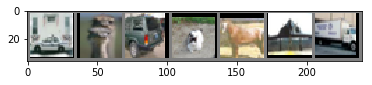

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# # show images
imshow(torchvision.utils.make_grid(images[0:7],nrow = 8))
# print labels
print(''.join('%5s' % classes[labels[j]] for j in range(7)))

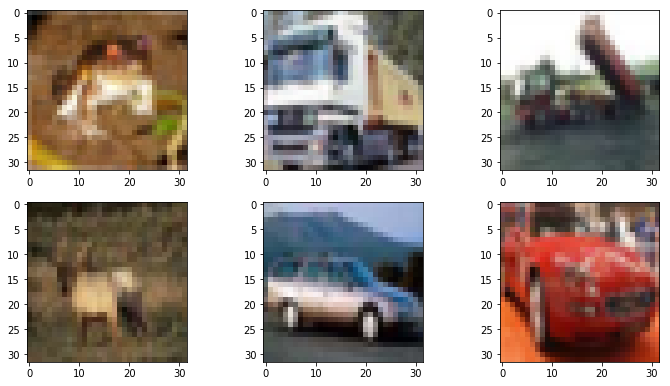

In [4]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. Later on I shifted to VGG networks which gave better accuracy. 
* After Implementing different VGG Networks, VGG13 gave the best results. 



In [5]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 10)]
#         layers += [nn.LogSoftmax(dim=1)]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG13')
# net = shufflenetv2
net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark = True


In [6]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(3072, 1536)
#         self.relu1 = nn.ReLU()
#         self.dout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(1536, 384)
#         self.relu2 = nn.ReLU()
#         self.dout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(384, 64)
#         self.prelu = nn.PReLU(1)
#         self.out = nn.Linear(64, 10)
#         self.out_act = nn.LogSoftmax(dim =1)

#     def swish(self,x):
#         return x * torch.sigmoid(x)
        
#     def forward(self, input_):
#         inpu = input_.view(input_.size(0), -1)
#         x = self.fc1(inpu)
#         x = self.relu1(x)
#         x = self.dout(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.dout2(x)
#         x = self.fc3(x)
#         x = self.prelu(x)
#         y = self.out(x)
#         y = (self.out_act(x))
#         return y
# net = Net()
# net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)


In [7]:
net

DataParallel(
  (module): VGG(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [8]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]           1,792
       BatchNorm2d-3           [-1, 64, 32, 32]             128
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

## Explanations for Network Architecture

* The Loss function used is cross entropy class as there are multiple classes (10)
* The model architecture adopted was that of VGG 13. This is because: 
     * the accuracy was in the range of 64 – 71 percent with a 5 layer network (input – conv1 – conv2- linear - crossentropyloss) .
    * Convolutions were used as the input is 2D images. 
    * Even after adding dropouts of 0.2 and 0.5 in between the convolution layers the accuracy did not improve.
     * Conclusion: as the networks needs to learn RGB images and distinguish 10 labels, it will need more parameters to shatter the input space.  Also the images are very blurry, this adds on to the number of parameters needed as differentiating becomes more difficult.
* VGG 11 also did not give accuracies above 75 percent. As I was able to get descent accuracy with Vgg 13, I did not experiment with this network.
* The Optimizer with Vgg13 is taken as Adam, as it got me better accuracies than SGD. This may be because Adam is able to avoid local minima and does not get stuck. 
* Learning rate of 0.002 gets me a good error convergence graph. Increase the learning rate to 0.01 also gives similar results much faster, but then convergence graph is like a step function and therefore avoided.
* Some other experimentation with dropouts and different activations like (swish, relu and Prelu) can be seen in the screen shot of the excel file I made in the Ipython Notebook.

* Each filter or weights of the convolution layers is visualized, in the image shown below.
    * The image is a representation of weights of the first kernel in each layer (only a depth size of 3 is visualized for each convolution layer)
    * we can see that the weights initialized is different for each layer. ( as they have different colors).


## Visualizaing Weights

In [9]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0:3])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Showing the weights of the first kernel in each convolution layer
(64, 3, 3, 3)


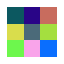

(64, 64, 3, 3)


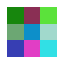

(128, 64, 3, 3)


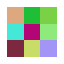

(128, 128, 3, 3)


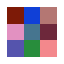

(256, 128, 3, 3)


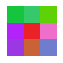

(256, 256, 3, 3)


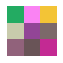

(512, 256, 3, 3)


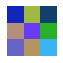

(512, 512, 3, 3)


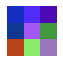

(512, 512, 3, 3)


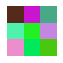

(512, 512, 3, 3)


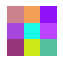

In [10]:
visnet = VGG('VGG13') #Net()
visnet = visnet.to('cpu').double()
print("Showing the weights of the first kernel in each convolution layer")
for m in visnet.modules():
    if isinstance(m, nn.Conv2d):   
        a = m.weight.data.numpy()
#         print(tensor.max())
        c = (a - np.min(a))/np.ptp(a).astype(float)
        print(c.shape)
        plot_kernels(c)
#         break


##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
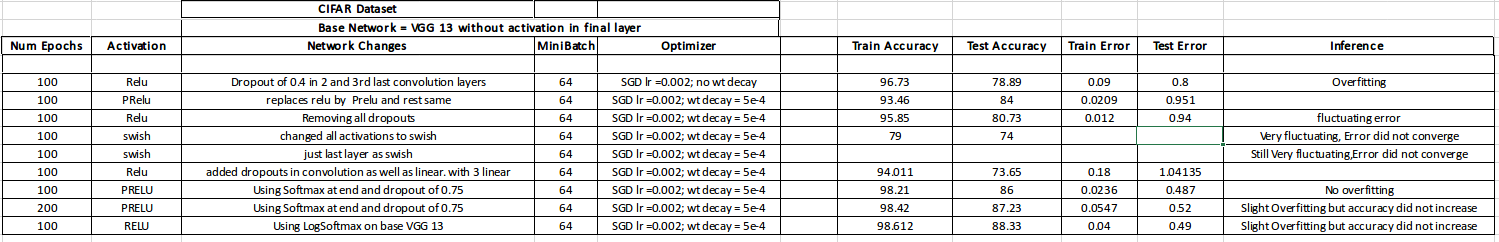
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
# optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]
best_acc= 0  # best test accuracy


In [12]:
device

'cuda'

In [13]:
# # For Debugging
for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     loss.backward()
#     optimizer.step()
    break
# # target

In [14]:
data.view(data.size(0), -1).shape

torch.Size([128, 3072])

## Training and Testing Functions

In [15]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    global best_acc
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Save checkpoint.
    acc = 100.*correct/len(test_loader.dataset)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'val_loss': val_loss,
            'test_accu': test_accu, 
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
    best_acc = acc

## Resume trained network if needed 

In [16]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [17]:
# a= net.state_dict(checkpoint['val_loss'])

# Training the Model

In [18]:
for epoch in range(start_epoch, 100):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.350652
Train Epoch: 0 [2560/50000 (5%)]	Loss: 1.970673
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.727877
Train Epoch: 0 [7680/50000 (15%)]	Loss: 1.643043
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.534079
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.607182
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.465723
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.426102
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.457444
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.467940
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.327806
Train Epoch: 0 [28160/50000 (56%)]	Loss: 1.285464
Train Epoch: 0 [30720/50000 (61%)]	Loss: 1.433695
Train Epoch: 0 [33280/50000 (66%)]	Loss: 1.477747
Train Epoch: 0 [35840/50000 (72%)]	Loss: 1.305723
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.311291
Train Epoch: 0 [40960/50000 (82%)]	Loss: 1.345603
Train Epoch: 0 [43520/50000 (87%)]	Loss: 1.324326
Train Epoch: 0 [46080/50000 (92%)]	Loss: 1.305132
Train Epoch: 0 [48640/50000 (97%)]	Loss: 1.213634

Test set

Train Epoch: 7 [40960/50000 (82%)]	Loss: 0.602869
Train Epoch: 7 [43520/50000 (87%)]	Loss: 0.583520
Train Epoch: 7 [46080/50000 (92%)]	Loss: 0.496431
Train Epoch: 7 [48640/50000 (97%)]	Loss: 0.555041

Test set: Average loss: 0.6153, Accuracy: 7895/10000 (79%)

Saving..
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.503838
Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.474002
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.581407
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.540952
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.671484
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.560997
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.519625
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.428890
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.512867
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.397762
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.495582
Train Epoch: 8 [28160/50000 (56%)]	Loss: 0.535430
Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.673802
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.490424
Train Epoch: 8 [35840/50000 (72%)]	Loss

Train Epoch: 15 [23040/50000 (46%)]	Loss: 0.421752
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.487091
Train Epoch: 15 [28160/50000 (56%)]	Loss: 0.359600
Train Epoch: 15 [30720/50000 (61%)]	Loss: 0.286605
Train Epoch: 15 [33280/50000 (66%)]	Loss: 0.203750
Train Epoch: 15 [35840/50000 (72%)]	Loss: 0.425607
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.387283
Train Epoch: 15 [40960/50000 (82%)]	Loss: 0.327229
Train Epoch: 15 [43520/50000 (87%)]	Loss: 0.298943
Train Epoch: 15 [46080/50000 (92%)]	Loss: 0.451549
Train Epoch: 15 [48640/50000 (97%)]	Loss: 0.331428

Test set: Average loss: 0.4973, Accuracy: 8329/10000 (83%)

Saving..
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.293414
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.382577
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.327526
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.339712
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.291887
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.295575
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.375274
Train Epoch: 16 [1792

Train Epoch: 23 [2560/50000 (5%)]	Loss: 0.253158
Train Epoch: 23 [5120/50000 (10%)]	Loss: 0.280915
Train Epoch: 23 [7680/50000 (15%)]	Loss: 0.307938
Train Epoch: 23 [10240/50000 (20%)]	Loss: 0.230190
Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.223618
Train Epoch: 23 [15360/50000 (31%)]	Loss: 0.301636
Train Epoch: 23 [17920/50000 (36%)]	Loss: 0.279844
Train Epoch: 23 [20480/50000 (41%)]	Loss: 0.396936
Train Epoch: 23 [23040/50000 (46%)]	Loss: 0.158711
Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.277443
Train Epoch: 23 [28160/50000 (56%)]	Loss: 0.405645
Train Epoch: 23 [30720/50000 (61%)]	Loss: 0.234721
Train Epoch: 23 [33280/50000 (66%)]	Loss: 0.224779
Train Epoch: 23 [35840/50000 (72%)]	Loss: 0.333033
Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.265375
Train Epoch: 23 [40960/50000 (82%)]	Loss: 0.261182
Train Epoch: 23 [43520/50000 (87%)]	Loss: 0.398070
Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.330700
Train Epoch: 23 [48640/50000 (97%)]	Loss: 0.285495

Test set: Average loss: 0.4688, Ac

Train Epoch: 30 [35840/50000 (72%)]	Loss: 0.114167
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.174394
Train Epoch: 30 [40960/50000 (82%)]	Loss: 0.153249
Train Epoch: 30 [43520/50000 (87%)]	Loss: 0.212960
Train Epoch: 30 [46080/50000 (92%)]	Loss: 0.217246
Train Epoch: 30 [48640/50000 (97%)]	Loss: 0.163927

Test set: Average loss: 0.4478, Accuracy: 8607/10000 (86%)

Saving..
Train Epoch: 31 [0/50000 (0%)]	Loss: 0.151109
Train Epoch: 31 [2560/50000 (5%)]	Loss: 0.231496
Train Epoch: 31 [5120/50000 (10%)]	Loss: 0.167606
Train Epoch: 31 [7680/50000 (15%)]	Loss: 0.133694
Train Epoch: 31 [10240/50000 (20%)]	Loss: 0.164538
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.166386
Train Epoch: 31 [15360/50000 (31%)]	Loss: 0.174978
Train Epoch: 31 [17920/50000 (36%)]	Loss: 0.165886
Train Epoch: 31 [20480/50000 (41%)]	Loss: 0.203836
Train Epoch: 31 [23040/50000 (46%)]	Loss: 0.190161
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.287153
Train Epoch: 31 [28160/50000 (56%)]	Loss: 0.244474
Train Epoch: 31 [3072

Train Epoch: 38 [15360/50000 (31%)]	Loss: 0.132311
Train Epoch: 38 [17920/50000 (36%)]	Loss: 0.179129
Train Epoch: 38 [20480/50000 (41%)]	Loss: 0.198735
Train Epoch: 38 [23040/50000 (46%)]	Loss: 0.202697
Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.194798
Train Epoch: 38 [28160/50000 (56%)]	Loss: 0.139238
Train Epoch: 38 [30720/50000 (61%)]	Loss: 0.135466
Train Epoch: 38 [33280/50000 (66%)]	Loss: 0.200485
Train Epoch: 38 [35840/50000 (72%)]	Loss: 0.239609
Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.187476
Train Epoch: 38 [40960/50000 (82%)]	Loss: 0.128165
Train Epoch: 38 [43520/50000 (87%)]	Loss: 0.148967
Train Epoch: 38 [46080/50000 (92%)]	Loss: 0.131233
Train Epoch: 38 [48640/50000 (97%)]	Loss: 0.085621

Test set: Average loss: 0.4545, Accuracy: 8598/10000 (86%)

Saving..
Train Epoch: 39 [0/50000 (0%)]	Loss: 0.171844
Train Epoch: 39 [2560/50000 (5%)]	Loss: 0.098320
Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.216842
Train Epoch: 39 [7680/50000 (15%)]	Loss: 0.123603
Train Epoch: 39 [1024

Train Epoch: 45 [48640/50000 (97%)]	Loss: 0.117032

Test set: Average loss: 0.4453, Accuracy: 8676/10000 (87%)

Saving..
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.142803
Train Epoch: 46 [2560/50000 (5%)]	Loss: 0.114289
Train Epoch: 46 [5120/50000 (10%)]	Loss: 0.114043
Train Epoch: 46 [7680/50000 (15%)]	Loss: 0.215673
Train Epoch: 46 [10240/50000 (20%)]	Loss: 0.079510
Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.158673
Train Epoch: 46 [15360/50000 (31%)]	Loss: 0.170688
Train Epoch: 46 [17920/50000 (36%)]	Loss: 0.077580
Train Epoch: 46 [20480/50000 (41%)]	Loss: 0.176646
Train Epoch: 46 [23040/50000 (46%)]	Loss: 0.131718
Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.094294
Train Epoch: 46 [28160/50000 (56%)]	Loss: 0.174527
Train Epoch: 46 [30720/50000 (61%)]	Loss: 0.067719
Train Epoch: 46 [33280/50000 (66%)]	Loss: 0.089960
Train Epoch: 46 [35840/50000 (72%)]	Loss: 0.101520
Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.164380
Train Epoch: 46 [40960/50000 (82%)]	Loss: 0.201921
Train Epoch: 46 [4352

Train Epoch: 53 [28160/50000 (56%)]	Loss: 0.101091
Train Epoch: 53 [30720/50000 (61%)]	Loss: 0.117725
Train Epoch: 53 [33280/50000 (66%)]	Loss: 0.208424
Train Epoch: 53 [35840/50000 (72%)]	Loss: 0.088351
Train Epoch: 53 [38400/50000 (77%)]	Loss: 0.061797
Train Epoch: 53 [40960/50000 (82%)]	Loss: 0.072304
Train Epoch: 53 [43520/50000 (87%)]	Loss: 0.044903
Train Epoch: 53 [46080/50000 (92%)]	Loss: 0.144261
Train Epoch: 53 [48640/50000 (97%)]	Loss: 0.081545

Test set: Average loss: 0.4544, Accuracy: 8714/10000 (87%)

Saving..
Train Epoch: 54 [0/50000 (0%)]	Loss: 0.149704
Train Epoch: 54 [2560/50000 (5%)]	Loss: 0.137750
Train Epoch: 54 [5120/50000 (10%)]	Loss: 0.082493
Train Epoch: 54 [7680/50000 (15%)]	Loss: 0.072201
Train Epoch: 54 [10240/50000 (20%)]	Loss: 0.069287
Train Epoch: 54 [12800/50000 (26%)]	Loss: 0.088160
Train Epoch: 54 [15360/50000 (31%)]	Loss: 0.089494
Train Epoch: 54 [17920/50000 (36%)]	Loss: 0.084523
Train Epoch: 54 [20480/50000 (41%)]	Loss: 0.037645
Train Epoch: 54 [2304

Train Epoch: 61 [7680/50000 (15%)]	Loss: 0.047131
Train Epoch: 61 [10240/50000 (20%)]	Loss: 0.066572
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.066310
Train Epoch: 61 [15360/50000 (31%)]	Loss: 0.136133
Train Epoch: 61 [17920/50000 (36%)]	Loss: 0.069365
Train Epoch: 61 [20480/50000 (41%)]	Loss: 0.055058
Train Epoch: 61 [23040/50000 (46%)]	Loss: 0.079365
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.055068
Train Epoch: 61 [28160/50000 (56%)]	Loss: 0.061756
Train Epoch: 61 [30720/50000 (61%)]	Loss: 0.130385
Train Epoch: 61 [33280/50000 (66%)]	Loss: 0.091546
Train Epoch: 61 [35840/50000 (72%)]	Loss: 0.101529
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.044257
Train Epoch: 61 [40960/50000 (82%)]	Loss: 0.091934
Train Epoch: 61 [43520/50000 (87%)]	Loss: 0.141442
Train Epoch: 61 [46080/50000 (92%)]	Loss: 0.102285
Train Epoch: 61 [48640/50000 (97%)]	Loss: 0.054487

Test set: Average loss: 0.4606, Accuracy: 8724/10000 (87%)

Saving..
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.037071
Train Epoch: 62 [2

Train Epoch: 68 [40960/50000 (82%)]	Loss: 0.068063
Train Epoch: 68 [43520/50000 (87%)]	Loss: 0.058656
Train Epoch: 68 [46080/50000 (92%)]	Loss: 0.087418
Train Epoch: 68 [48640/50000 (97%)]	Loss: 0.063319

Test set: Average loss: 0.4750, Accuracy: 8751/10000 (88%)

Saving..
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.073707
Train Epoch: 69 [2560/50000 (5%)]	Loss: 0.050659
Train Epoch: 69 [5120/50000 (10%)]	Loss: 0.045216
Train Epoch: 69 [7680/50000 (15%)]	Loss: 0.070530
Train Epoch: 69 [10240/50000 (20%)]	Loss: 0.108711
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.055026
Train Epoch: 69 [15360/50000 (31%)]	Loss: 0.128256
Train Epoch: 69 [17920/50000 (36%)]	Loss: 0.084509
Train Epoch: 69 [20480/50000 (41%)]	Loss: 0.049371
Train Epoch: 69 [23040/50000 (46%)]	Loss: 0.136804
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.073169
Train Epoch: 69 [28160/50000 (56%)]	Loss: 0.068167
Train Epoch: 69 [30720/50000 (61%)]	Loss: 0.053849
Train Epoch: 69 [33280/50000 (66%)]	Loss: 0.150785
Train Epoch: 69 [3584

Train Epoch: 76 [20480/50000 (41%)]	Loss: 0.058819
Train Epoch: 76 [23040/50000 (46%)]	Loss: 0.089132
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.065706
Train Epoch: 76 [28160/50000 (56%)]	Loss: 0.039433
Train Epoch: 76 [30720/50000 (61%)]	Loss: 0.048226
Train Epoch: 76 [33280/50000 (66%)]	Loss: 0.039943
Train Epoch: 76 [35840/50000 (72%)]	Loss: 0.059967
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.099256
Train Epoch: 76 [40960/50000 (82%)]	Loss: 0.056454
Train Epoch: 76 [43520/50000 (87%)]	Loss: 0.063974
Train Epoch: 76 [46080/50000 (92%)]	Loss: 0.051246
Train Epoch: 76 [48640/50000 (97%)]	Loss: 0.059761

Test set: Average loss: 0.4718, Accuracy: 8748/10000 (87%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.044203
Train Epoch: 77 [2560/50000 (5%)]	Loss: 0.028894
Train Epoch: 77 [5120/50000 (10%)]	Loss: 0.067563
Train Epoch: 77 [7680/50000 (15%)]	Loss: 0.057886
Train Epoch: 77 [10240/50000 (20%)]	Loss: 0.092538
Train Epoch: 77 [12800/50000 (26%)]	Loss: 0.048314
Train Epoch: 77 [15360/50000 (

Train Epoch: 84 [0/50000 (0%)]	Loss: 0.042912
Train Epoch: 84 [2560/50000 (5%)]	Loss: 0.051162
Train Epoch: 84 [5120/50000 (10%)]	Loss: 0.030546
Train Epoch: 84 [7680/50000 (15%)]	Loss: 0.040421
Train Epoch: 84 [10240/50000 (20%)]	Loss: 0.042046
Train Epoch: 84 [12800/50000 (26%)]	Loss: 0.065984
Train Epoch: 84 [15360/50000 (31%)]	Loss: 0.066672
Train Epoch: 84 [17920/50000 (36%)]	Loss: 0.027231
Train Epoch: 84 [20480/50000 (41%)]	Loss: 0.018764
Train Epoch: 84 [23040/50000 (46%)]	Loss: 0.097562
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.048228
Train Epoch: 84 [28160/50000 (56%)]	Loss: 0.030482
Train Epoch: 84 [30720/50000 (61%)]	Loss: 0.055239
Train Epoch: 84 [33280/50000 (66%)]	Loss: 0.051586
Train Epoch: 84 [35840/50000 (72%)]	Loss: 0.062795
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.039294
Train Epoch: 84 [40960/50000 (82%)]	Loss: 0.097748
Train Epoch: 84 [43520/50000 (87%)]	Loss: 0.021579
Train Epoch: 84 [46080/50000 (92%)]	Loss: 0.056711
Train Epoch: 84 [48640/50000 (97%)]	Loss

Train Epoch: 91 [35840/50000 (72%)]	Loss: 0.044809
Train Epoch: 91 [38400/50000 (77%)]	Loss: 0.047895
Train Epoch: 91 [40960/50000 (82%)]	Loss: 0.038697
Train Epoch: 91 [43520/50000 (87%)]	Loss: 0.062336
Train Epoch: 91 [46080/50000 (92%)]	Loss: 0.066468
Train Epoch: 91 [48640/50000 (97%)]	Loss: 0.061633

Test set: Average loss: 0.4697, Accuracy: 8804/10000 (88%)

Saving..
Train Epoch: 92 [0/50000 (0%)]	Loss: 0.047636
Train Epoch: 92 [2560/50000 (5%)]	Loss: 0.017835
Train Epoch: 92 [5120/50000 (10%)]	Loss: 0.022466
Train Epoch: 92 [7680/50000 (15%)]	Loss: 0.011111
Train Epoch: 92 [10240/50000 (20%)]	Loss: 0.029868
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.029779
Train Epoch: 92 [15360/50000 (31%)]	Loss: 0.022785
Train Epoch: 92 [17920/50000 (36%)]	Loss: 0.048440
Train Epoch: 92 [20480/50000 (41%)]	Loss: 0.082600
Train Epoch: 92 [23040/50000 (46%)]	Loss: 0.047321
Train Epoch: 92 [25600/50000 (51%)]	Loss: 0.019489
Train Epoch: 92 [28160/50000 (56%)]	Loss: 0.017993
Train Epoch: 92 [3072

Train Epoch: 99 [15360/50000 (31%)]	Loss: 0.036812
Train Epoch: 99 [17920/50000 (36%)]	Loss: 0.027716
Train Epoch: 99 [20480/50000 (41%)]	Loss: 0.018412
Train Epoch: 99 [23040/50000 (46%)]	Loss: 0.025171
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.027375
Train Epoch: 99 [28160/50000 (56%)]	Loss: 0.034222
Train Epoch: 99 [30720/50000 (61%)]	Loss: 0.020754
Train Epoch: 99 [33280/50000 (66%)]	Loss: 0.030600
Train Epoch: 99 [35840/50000 (72%)]	Loss: 0.024949
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.016054
Train Epoch: 99 [40960/50000 (82%)]	Loss: 0.038933
Train Epoch: 99 [43520/50000 (87%)]	Loss: 0.028505
Train Epoch: 99 [46080/50000 (92%)]	Loss: 0.093573
Train Epoch: 99 [48640/50000 (97%)]	Loss: 0.051260

Test set: Average loss: 0.4919, Accuracy: 8788/10000 (88%)



## Resume trained network

In [19]:
# print('==> Resuming from checkpoint..')
# assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
# checkpoint = torch.load('./checkpoint/ckpt.t7')
# net.load_state_dict(checkpoint['net'])
# best_acc = checkpoint['acc']
# start_epoch = checkpoint['epoch']

In [20]:
start_epoch

0

Training Loss: 0.03599149172129991
Training Accuracy: 98.824

Test Loss: 0.4972473312072456
Testing Accuracy: 88.55



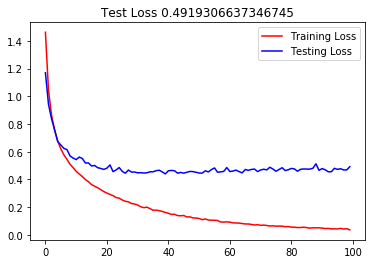

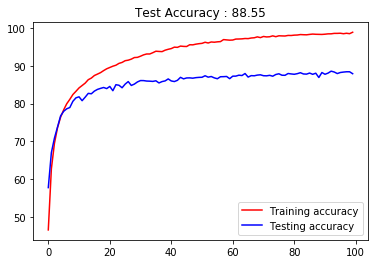

In [21]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


In [22]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
classlabels = ['airplane', 'automobile', 'bird', 'cat' , 'deer' , 'dog', 'frog', 'horse', 'ship', 'truck']
n = 6   # Number of False predictions to output

vis_loader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)


# vis_loader = torch.utils.data.DataLoader(
#     FlowerLoader(x_test, y_test, transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         normalize,
#     ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    


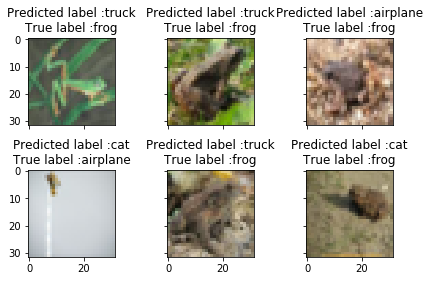

In [23]:
#======= Plotting Incorrect=======
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                              classlabels[targetlabel[maxerrorind[num]]]))
        num = num+1
fig.tight_layout()

## Correct Predictions

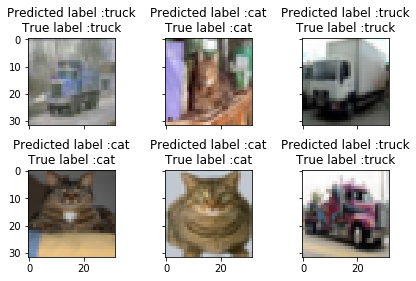

In [24]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num =  0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[maxerrorind[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictedlabel[maxerrorind[num]]],
                                                                               classlabels[targetlabel[maxerrorind[num]]]))
        num = num + 1
fig.tight_layout()

### 2) Implementing using Local Binary Pattern

In [25]:
from skimage import feature
import numpy as np
from sklearn.svm import LinearSVC  
import argparse
import cv2
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from keras.datasets import cifar10


In [36]:
numPoints = 48
radius = 1
def describe(image, eps=1e-7):
# compute the Local Binary Pattern representation
# of the image, and then use the LBP representation
# to build the histogram of patterns
    lbp = feature.local_binary_pattern(image,numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2)) 
# # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    # return the histogram of Local Binary Patterns
    return hist

In [37]:
data = []
labels = []
for i in range(0,x_train.shape[0]):
    img = x_train[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    labels.append(y_train[i])
    data.append(hist)
#     print(hist.shape)
#     break
# np.save('train_data.npy',data)
# np.save('train_label.npy',labels)    

In [38]:
# train a Linear SVM on the data
# data = np.load('train_data.npy')
# labels = np.load('train_label.npy')   
svclassifier = LinearSVC(tol=1e-5)  
h = svclassifier.fit(data, labels)  

/home/anirudh/detect/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
acc = [] 
predictlabel=[]
# loop over the testing images
for i in range(0,x_test.shape[0]):
    img = x_test[i]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = describe(gray)
    prediction = h.predict(hist.reshape(1, -1))
    acc.append(prediction == y_test[i])
    predictlabel.append(prediction)
acc = np.asarray(acc)*1    
print('Test Accuracy = ' + str(np.mean(acc)))

Test Accuracy = 0.2983


In [33]:
## Plotting Training VS Epoch Plots
# Function taken from (Kaggle) https://www.kaggle.com/paul92s/linear-svc-classifier#


def plot_learning_curve(estimator, title, x1, y1, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x1, y1, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# title = "Learning Curves ( Linear SVM)"
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# plot_learning_curve(h, title, data, labels, cv=cv)

# plt.show()


## Incorrect Predictions

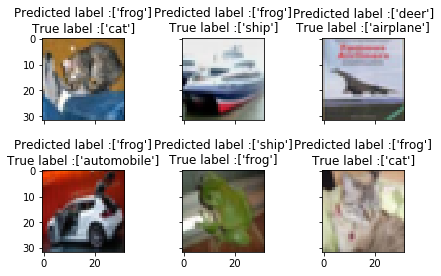

In [34]:
index =  np.where(acc == 0)[0]
classlabels=np.asarray(classlabels) 
#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[index[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictlabel[index[num]].astype(int)],
                                                                              classlabels[y_test[index[num]].astype(int)]))
        num = num+1
fig.tight_layout()

## Correct Predictions

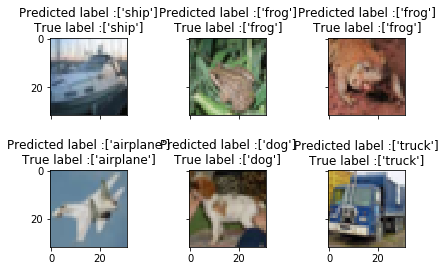

In [35]:
posindex =  np.where(acc == 1)[0]
#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
num = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(x_test[posindex[num]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(classlabels[predictlabel[posindex[num]].astype(int)],
                                                                              classlabels[y_test[posindex[num]].astype(int)]))
        num = num+1
fig.tight_layout()